In [1]:
#Load the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import torch
import torch.nn as nn

In [4]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-08-14 05:32:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-08-14 05:32:23 (38.2 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [8]:
#read the airlines data
data=pd.read_csv("airline-passengers.csv",usecols=[1])

In [9]:
data

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


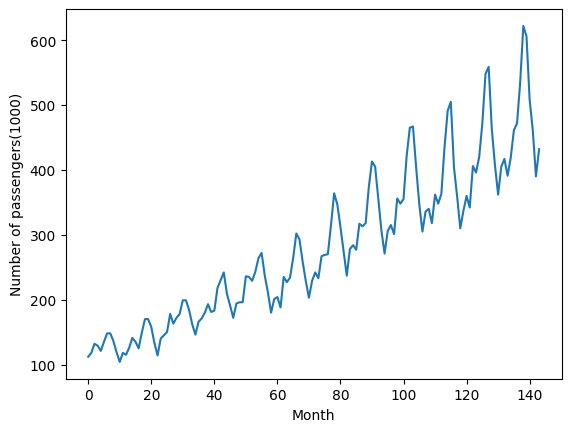

In [11]:
#let`s plot the data

plt.xlabel('Month')
plt.ylabel('Number of passengers(1000)')
plt.plot(data)
plt.show()

In [12]:
#scale the data
from sklearn.preprocessing import MinMaxScaler

In [13]:
scale=MinMaxScaler(feature_range=(0,1))
data=scale.fit_transform(data)

In [14]:
#divide the data into number of steps

def create_data(data,seq_len):
  N=len(data)
  X=[]
  Y=[]

  for i in range(N-seq_len-1):
    x=data[i:i+seq_len]
    X.append(x)
    y=data[i+seq_len]
    Y.append(y)

  return X,Y

In [15]:
x,y=create_data(data,10)

In [16]:
#convert the x and y values into arrays
x,y=np.asarray(x),np.asarray(y)

In [17]:
x.reshape(-1,10).shape

(133, 10)

In [19]:
#divide teh data into train and test

def split_data(x,y,ratio):
  assert len(x)==len(y)
  N=len(y)
  train_x,test_x=x[:int(N*ratio)],x[int(N*ratio):]
  train_y,test_y=y[:int(N*ratio)],y[int(N*ratio):]
  return train_x,train_y,test_x,test_y


In [20]:
train_x,train_y,test_x,test_y=split_data(x,y,0.7)

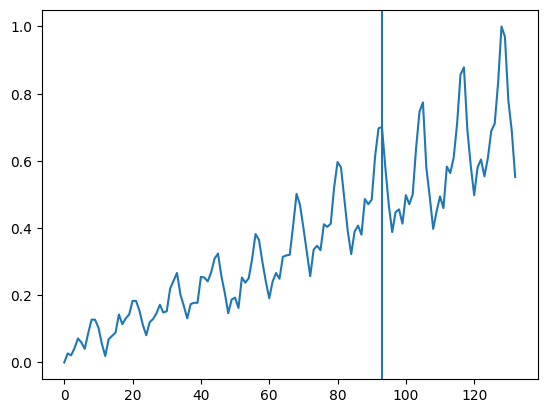

In [22]:
plt.plot(np.vstack((train_y,test_y)))
plt.axvline(int(len(x)*0.7))

In [23]:
from sqlalchemy.sql.expression import true
#implement RNN
class Simple_RNN(nn.Module):
  def __init__(self,in_dim,hid_dim,out_dim,num_layers):
    super().__init__()

    #define the dimensions
    self.in_dim=in_dim
    self.hid_dim=in_dim
    self.out_dim=out_dim
    self.layer=num_layers

    #define the rnn layer
    self.rnn=nn.RNN(self.in_dim,self.hid_dim,self.layer,nonlinearity='tanh',batch_first=True)

    #define the fully connected layer for output
    self.fc=nn.Linear(self.hid_dim,self.out_dim)

  def forward(self,x):

    #initialize the hidden layer
    h0=torch.zeros(self.layer,x.size(0),self.hid_dim)

    #initialize the rnn
    out,_=self.rnn(x,h0)

    out=self.fc(out[:,-1,:])
    return out


In [24]:
#convert the data from numpy to tensor
train_x=torch.from_numpy(train_x.astype(np.float32))
train_y=torch.from_numpy(train_y.astype(np.float32))
test_x=torch.from_numpy(test_x.astype(np.float32))
test_y=torch.from_numpy(test_y.astype(np.float32))

In [25]:
x.shape

(133, 10, 1)

In [26]:
#define the network
in_size=x.shape[-1]
out_size=in_size
hid_size=3
num_layers=1

model=Simple_RNN(in_size,hid_size,out_size,num_layers)

optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
loss_fun=nn.MSELoss()

In [30]:
def train_model(model,criterion,optimizer,x_train,x_test,y_train,y_test,epochs=500):

  train_loss=np.zeros(epochs)
  test_loss=np.zeros(epochs)

  for epoch in range(epochs):

    #put default model grad to zero
    optimizer.zero_grad()

    #predict the output
    pred=model(x_train)

    #calculate the loss
    error=criterion(pred,y_train)

    #backpropagate the error
    error.backward()

    #update the model parameters
    optimizer.step()

    #save the losses
    train_loss[epoch]=error.item()

    #test loss
    test_pred=model(x_test)
    test_error=criterion(y_test,test_pred)
    test_loss[epoch]=test_error.item()

    if (epoch+1)% 5==0:
      print('Epoch :{}  Train Loss: {}  Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))

  return train_loss,test_loss


In [31]:
train_loss, test_loss = train_model(model,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01  Train Loss: 0.01884855329990387  Test Loss :0.13244353234767914
Epoch :0.02  Train Loss: 0.018683744594454765  Test Loss :0.13159532845020294
Epoch :0.03  Train Loss: 0.018507635220885277  Test Loss :0.130690336227417
Epoch :0.04  Train Loss: 0.018319325521588326  Test Loss :0.12972380220890045
Epoch :0.05  Train Loss: 0.018117867410182953  Test Loss :0.12869048118591309
Epoch :0.06  Train Loss: 0.017902273684740067  Test Loss :0.12758469581604004
Epoch :0.07  Train Loss: 0.017671508714556694  Test Loss :0.12640035152435303
Epoch :0.08  Train Loss: 0.017424536868929863  Test Loss :0.1251310110092163
Epoch :0.09  Train Loss: 0.01716030389070511  Test Loss :0.12376979738473892
Epoch :0.1  Train Loss: 0.01687779650092125  Test Loss :0.12230970710515976
Epoch :0.11  Train Loss: 0.016576053574681282  Test Loss :0.12074341624975204
Epoch :0.12  Train Loss: 0.016254208981990814  Test Loss :0.11906366050243378
Epoch :0.13  Train Loss: 0.015911545604467392  Test Loss :0.11726329475

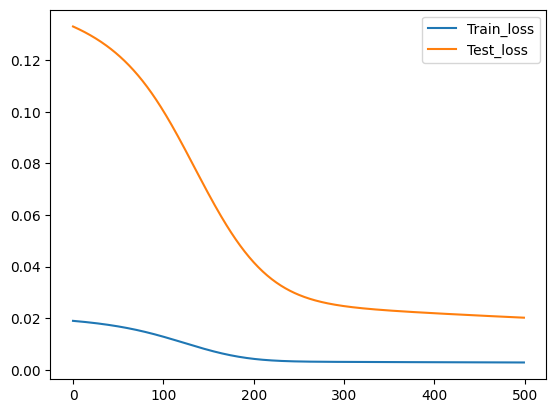

In [32]:
plt.plot(train_loss, label='Train_loss')
plt.plot(test_loss,label='Test_loss')
plt.legend()

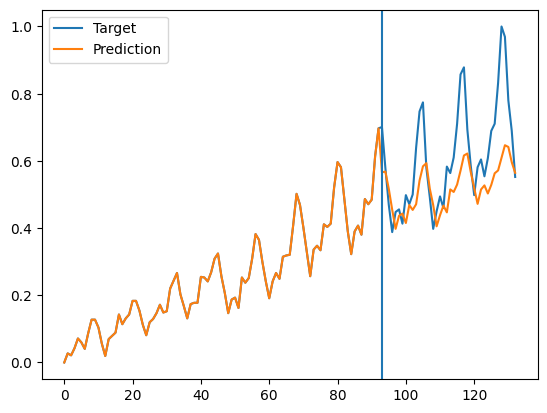

In [33]:
#testing the predition quality if the trained model
#1) Multi step prediction
#plt.plot(train_y.detach().numpy())

plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),model(test_x).detach().numpy())),label='Prediction')
plt.axvline(int(len(x)*0.7))
plt.legend()

In [34]:
#testing the prediction model on the multiple time series
last_x=train_x[-1].view(10)

prediction_val=[]

while len(prediction_val)<len(test_y):
  prediction=model(last_x.view(1,10,1))
  prediction_val.append(prediction[0,0].item())

  ##replace the predicted value in last x
  last_x=torch.cat((last_x[1:],prediction[0]))

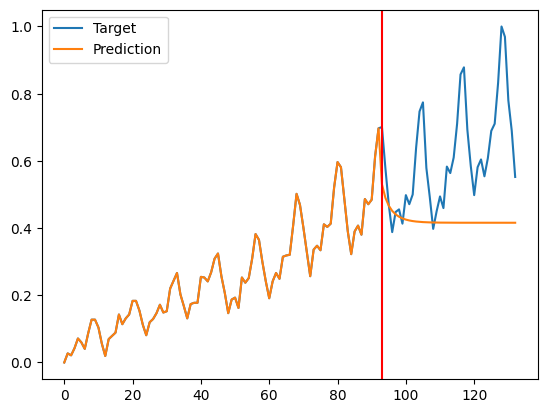

In [35]:
#plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Prediction')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [43]:
#implement LSTM
class LSTM(nn.Module):
  def __init__(self,in_dim,hid_dim,out_dim,num_layers):
    super().__init__()
    self.in_dim=in_dim
    self.hid_dim=hid_dim
    self.out_dim=out_dim
    self.num_layers=num_layers

    self.lstm=nn.LSTM(self.in_dim,self.hid_dim,self.num_layers,batch_first=True)

    self.fc=nn.Linear(self.hid_dim,self.out_dim)

  def forward(self,x):

    #initialize the hidden state
    h0=torch.zeros(self.num_layers,x.size(0),self.hid_dim)
    c0=torch.zeros(self.num_layers,x.size(0),self.hid_dim)

    #forward propagate
    out,(h_,c_)=self.lstm(x,(h0,c0))

    out=self.fc(out[:,-1,:])
    return out

In [44]:
#define the network
in_size=x.shape[-1]
out_size=in_size
hid_size=5
num_layers=1

lstm=LSTM(in_size,hid_size,out_size,num_layers)

optimizer=torch.optim.Adam(lstm.parameters(),lr=0.01)
loss_fun=nn.MSELoss()

In [45]:
train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01  Train Loss: 0.017849991098046303  Test Loss :0.0937420129776001
Epoch :0.02  Train Loss: 0.02044370397925377  Test Loss :0.07670052349567413
Epoch :0.03  Train Loss: 0.015616235323250294  Test Loss :0.10151078552007675
Epoch :0.04  Train Loss: 0.014635407365858555  Test Loss :0.09654541313648224
Epoch :0.05  Train Loss: 0.010317930951714516  Test Loss :0.051207441836595535
Epoch :0.06  Train Loss: 0.006732320878654718  Test Loss :0.02709171175956726
Epoch :0.07  Train Loss: 0.005093882791697979  Test Loss :0.018153944984078407
Epoch :0.08  Train Loss: 0.005224520340561867  Test Loss :0.017851030454039574
Epoch :0.09  Train Loss: 0.004375442862510681  Test Loss :0.019565461203455925
Epoch :0.1  Train Loss: 0.004604045767337084  Test Loss :0.022730184718966484
Epoch :0.11  Train Loss: 0.004446954000741243  Test Loss :0.020388726145029068
Epoch :0.12  Train Loss: 0.004230054561048746  Test Loss :0.018009845167398453
Epoch :0.13  Train Loss: 0.004239947535097599  Test Loss :0.

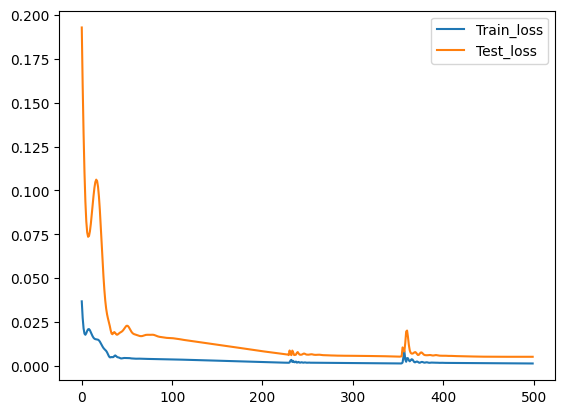

In [46]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test_loss')
plt.legend()

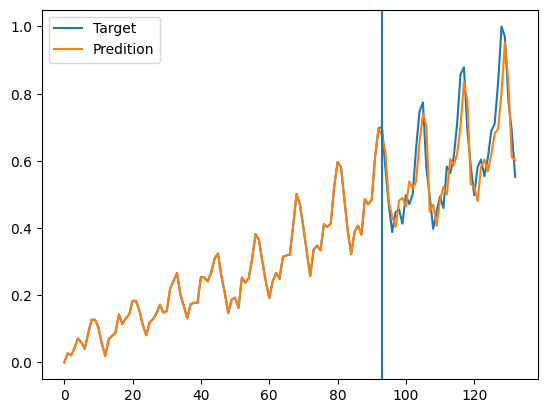

In [47]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),lstm(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

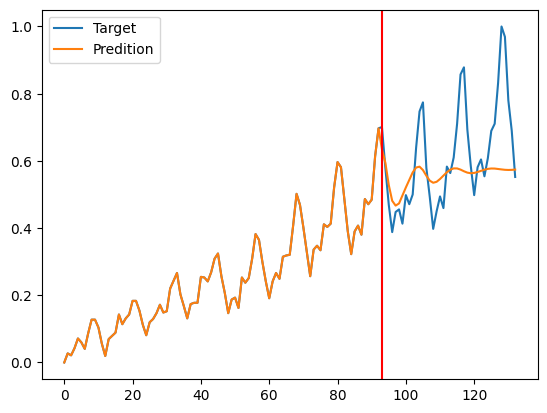

In [48]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [49]:
#Implement GRU
class GRU(nn.Module):
  def __init__(self,in_dim,hid_dim,out_dim,num_layer):
    super().__init__()

    self.in_dim=in_dim
    self.hid_dim=hid_dim
    self.out_dim=out_dim
    self.layer=num_layer

    self.gru=nn.GRU(self.in_dim,self.hid_dim,self.layer,batch_first=True)
    self.fc=nn.Linear(self.hid_dim,self.out_dim)

  def forward(self,x):

    #initialize the hidden Layers
    h0=torch.zeros(self.layer,x.size(0),self.hid_dim)

    out,_=self.gru(x,h0)
    out=self.fc(out[:,-1,:])
    return out

In [50]:
#define the network
in_size=x.shape[-1]
out_size=in_size
hid_size=5
num_layers=1

gru=GRU(in_size,hid_size,out_size,num_layers)

optimizer=torch.optim.Adam(gru.parameters(),lr=0.01)
loss_fun=nn.MSELoss()

In [51]:
train_loss,test_loss=train_model(gru,
                                 loss_fun,
                                 optimizer,
                                 train_x,
                                 test_x,
                                 train_y,
                                 test_y,
                                 epochs=500)

Epoch :0.01  Train Loss: 0.028511522337794304  Test Loss :0.14272287487983704
Epoch :0.02  Train Loss: 0.04322299733757973  Test Loss :0.041904475539922714
Epoch :0.03  Train Loss: 0.022647250443696976  Test Loss :0.08883149921894073
Epoch :0.04  Train Loss: 0.019605178385972977  Test Loss :0.1570412516593933
Epoch :0.05  Train Loss: 0.02100015990436077  Test Loss :0.14658018946647644
Epoch :0.06  Train Loss: 0.014979631640017033  Test Loss :0.09405392408370972
Epoch :0.07  Train Loss: 0.015433992259204388  Test Loss :0.06771562993526459
Epoch :0.08  Train Loss: 0.01362338475883007  Test Loss :0.07429184764623642
Epoch :0.09  Train Loss: 0.012308964505791664  Test Loss :0.08681495487689972
Epoch :0.1  Train Loss: 0.011636362411081791  Test Loss :0.07983756065368652
Epoch :0.11  Train Loss: 0.010340257547795773  Test Loss :0.06249687820672989
Epoch :0.12  Train Loss: 0.009614720940589905  Test Loss :0.053923241794109344
Epoch :0.13  Train Loss: 0.00860210508108139  Test Loss :0.05370602

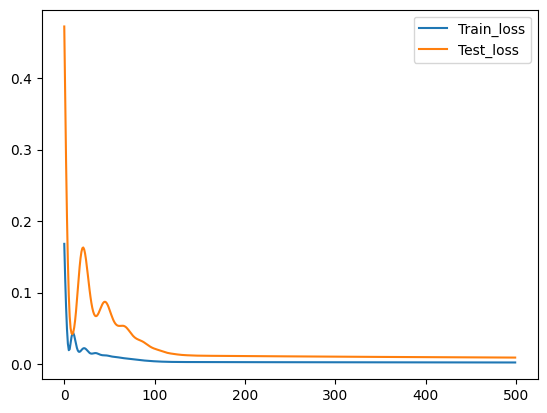

In [52]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test_loss')
plt.legend()

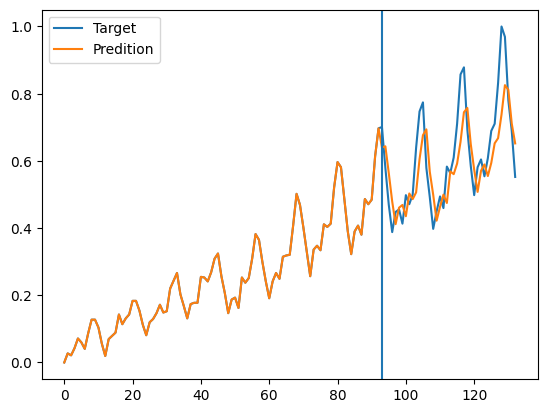

In [53]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),gru(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

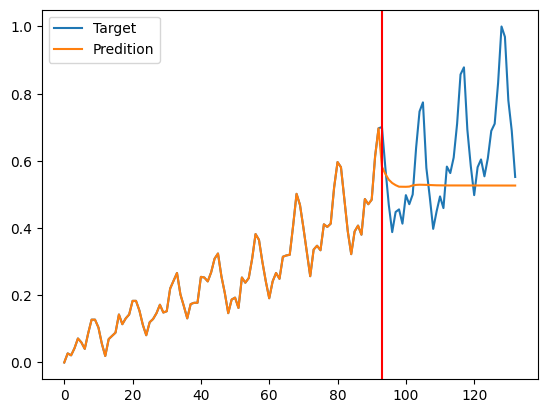

In [54]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = gru(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()

In [55]:
#Implment Autoregressive model
auto_reg=nn.Linear(10,1)
optimizer=torch.optim.Adam(auto_reg.parameters(),lr=0.01)
loss_fun=nn.MSELoss()

In [56]:
train_loss, test_loss = train_model(auto_reg,
               loss_fun,
               optimizer,
               train_x.reshape(-1,10),
               test_x.reshape(-1,10),
               train_y.reshape(-1,1),
               test_y.reshape(-1,1),
               epochs=500)

Epoch :0.01  Train Loss: 0.014020191505551338  Test Loss :0.08346076309680939
Epoch :0.02  Train Loss: 0.009590876288712025  Test Loss :0.032281823456287384
Epoch :0.03  Train Loss: 0.00726154912263155  Test Loss :0.018653539940714836
Epoch :0.04  Train Loss: 0.005074864253401756  Test Loss :0.02147524617612362
Epoch :0.05  Train Loss: 0.003983257804065943  Test Loss :0.01512038242071867
Epoch :0.06  Train Loss: 0.003382394788786769  Test Loss :0.012641936540603638
Epoch :0.07  Train Loss: 0.0030676787719130516  Test Loss :0.012293229810893536
Epoch :0.08  Train Loss: 0.003001907141879201  Test Loss :0.012162579223513603
Epoch :0.09  Train Loss: 0.0029377113096415997  Test Loss :0.012927539646625519
Epoch :0.1  Train Loss: 0.002852984005585313  Test Loss :0.011875515803694725
Epoch :0.11  Train Loss: 0.002760786795988679  Test Loss :0.011406381614506245
Epoch :0.12  Train Loss: 0.0026550977490842342  Test Loss :0.011085706762969494
Epoch :0.13  Train Loss: 0.00255143316462636  Test Los

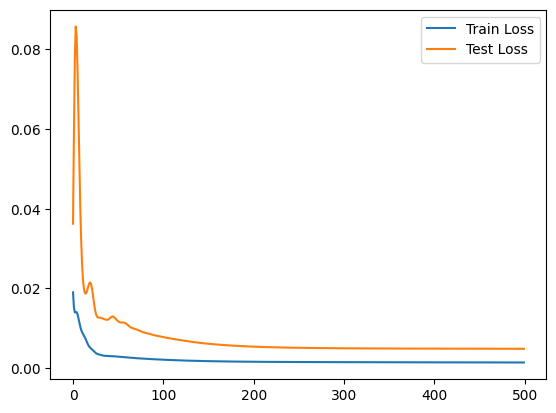

In [57]:
# plot the loss
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend();

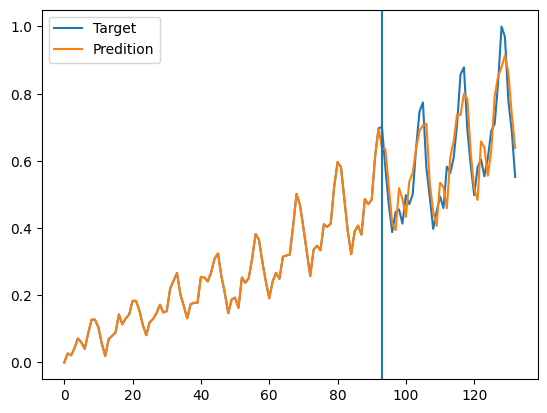

In [58]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),auto_reg(test_x.reshape(-1,10)).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

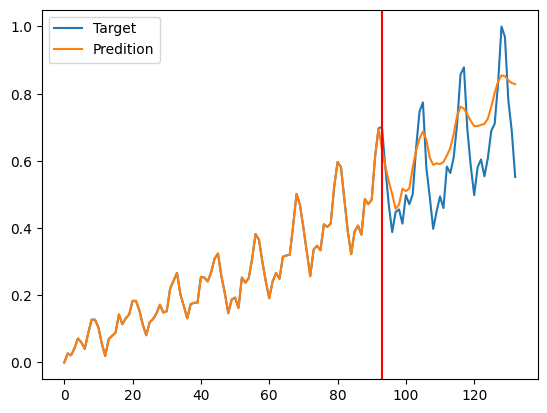

In [59]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = auto_reg(last_x.view(1,10))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()